In [28]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate,BatchNormalization
from keras.datasets import cifar100, cifar10, mnist
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
from keras import regularizers
from keras import optimizers
from keras import backend as K
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import torch
import random
import gc
#import seaborn as sns
import h5py
import sys

#import os
import pandas as pd
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
tf.config.run_functions_eagerly(True)
tf.config.experimental_run_functions_eagerly(True)

In [57]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [58]:
# https://github.com/wangz10/contrastive_loss/blob/master/losses.py


def random_resize_crop(image):
    start_x=random.randint(1,32)
    start_y=random.randint(1,32)
    height=random.randint(1,32)
    length=random.randint(1,32)

    for i in range(start_x, min(31, start_x+length)):
        for j in range(start_y, min(31, start_y+height)):
            image[i][j]=0
    return image
    
    

def color_jitter(x):
    s=1.0
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta=0.2 * s)
    # x = tf.clip_by_value(x, 0, 1)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x




def data_augmentation_2(image):

    number = tf.random.uniform(shape=[], minval=1, maxval=100)
    if (number<=40):
        image = random_resize_crop(image)
    elif (number<=70):
        image= color_jitter(image)
    else:
        image= color_drop(image)
    return image





In [59]:
## data
import random

x_train_aug=np.zeros_like(x_train)
y_train_aug= y_train.copy()
y_test_aug= y_test.copy()
x_test_aug=np.zeros_like(x_test)


# Train images process
for i in range(x_train.shape[0]):
    x= x_train[i].copy()
    x= data_augmentation_2(x)              #plt.imshow(x)
    x_train_aug[i]=x
x_train_aug= tf.image.convert_image_dtype(x_train_aug, dtype=tf.float32, saturate=False, name=None)


# Test images process
for i in range(x_test.shape[0]):
    x= x_test[i].copy()
    x= data_augmentation_2(x)              #plt.imshow(x)
    x_test_aug[i]=x
x_test_aug= tf.image.convert_image_dtype(x_test_aug, dtype=tf.float32, saturate=False, name=None)



n_train = x_train_aug.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train_shf = x_train[shuffle_idx][:n_train]
y_train_shf = y_train[shuffle_idx][:n_train]
y_train_shf= to_categorical(y_train_shf, num_classes)
y_train= to_categorical(y_train, num_classes)
y_test= to_categorical(y_test, num_classes)




print(f'Contrastive learning__ x_train_aug: {x_train_aug.shape}     y_train: {y_train_aug.shape}')
print(f'Contrastive evaluate__ x_test_aug: {x_test_aug.shape}     y_test: {y_test_aug.shape}')
print('\n')
print(f'Supervised learning__ x_train_shf: {x_train_shf.shape}     y_train_shf: {y_train_shf.shape}')
print(f'Supervised evaluate__ x_test: {x_test.shape}     y_test: {y_test.shape}')
print('\n')
print(f'Teacher learning__ x_train: {x_train.shape}     y_train: {y_train.shape}')



Contrastive learning__ x_train_aug: (50000, 32, 32, 3)     y_train: (50000, 1)
Contrastive evaluate__ x_test_aug: (10000, 32, 32, 3)     y_test: (10000, 1)


Supervised learning__ x_train_shf: (50000, 32, 32, 3)     y_train_shf: (50000, 100)
Supervised evaluate__ x_test: (10000, 32, 32, 3)     y_test: (10000, 100)


Teacher learning__ x_train: (50000, 32, 32, 3)     y_train: (50000, 100)


In [39]:
# Student model

def create_encoder():

    inputs = keras.Input(shape=input_shape)

    x= Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(inputs)
    x= BatchNormalization()(x)
    x= Dropout(0.3)(x)
    x= Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x= BatchNormalization()(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    x= Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x= BatchNormalization()(x)
    x= Dropout(0.4)(x)
    x= Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x= BatchNormalization()(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    
    model = keras.Model(inputs=inputs, outputs=x)
    
    return model





def create_classifier(encoder, trainable=True):
    global num_classes_s, hidden_units, dropout_rate, learning_rate

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = BatchNormalization()(features)
    features= layers.Dropout(dropout_rate)(features)
    features=layers.Dense(hidden_units)(features)
    features=layers.Activation('relu')(features)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(num_classes_s)(features)
    outputs=layers.Activation('softmax')(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate= learning_rate, decay= 1e-6, momentum=0.9, nesterov=True),
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        #metrics=[keras.metrics.CategoricalAccuracy()],
        metrics=['accuracy']
    )
    return model



def add_projection_head(encoder):
    global projection_units, dropout_rate
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features= Flatten()(features)
    features = layers.Dense(projection_units)(features)
    outputs = layers.Activation('relu')(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

In [40]:
def teacher_model(num_classes):

    global Temperature, sgd, y_true, y_pred

    teacher= Sequential()

    #teacher.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape= (32,32,3)))
    #teacher.add(BatchNormalization())
    #teacher.add(Dropout(0.3))

    #teacher.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization()) 

    #teacher.add(MaxPooling2D(pool_size=(2,2)))

    #teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization())
    #teacher.add(Dropout(0.4))

    #teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization())

    #teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (8,8,128)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization()) 

    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (4,4,256)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())


    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())

    teacher.add(MaxPooling2D(pool_size=(2,2)))
    teacher.add(Dropout(0.5))

    teacher.add(Flatten())
    teacher.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(Activation('relu'))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.5))

    teacher.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(Activation('relu'))
    teacher.add(Dropout(0.5))
    teacher.add(Dense(num_classes))
    teacher.add(Activation('softmax'))

    teacher.compile(optimizer=sgd, loss=lambda y_true,y_pred: teacher_loss(y_true, y_pred), metrics=['accuracy'])


    return teacher

In [41]:
def teacher_loss(y_true, y_pred):
    global count, num_classes_t, pred_sum, pred_avg, batchsize

    loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)
 
    return loss

In [60]:
# Student loss (Contrastive Learning)

def pdist_euclidean(A):
    # Euclidean pdist
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)

    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts

 
    
    
    
    
    
    
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)
    
    
    
class max_margin_contrastive_loss_euclidean(keras.losses.Loss):
    def __init__(self, margin=1.0, name=None):
        super(max_margin_contrastive_loss_euclidean, self).__init__(name=name)
        self.margin=margin
    def __call__(self,labels, feature_vectors, sample_weight=None):
        feature_vectors=tf.math.l2_normalize(feature_vectors, axis=1)
        D= pdist_euclidean(feature_vectors)
        d_vec= square_to_vec(D)
        y_contrasts= get_contrast_batch_labels(labels)
        loss= tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=self.margin)
        loss= tf.reduce_mean(loss)
        return loss
    


    
class max_margin_contrastive_loss_cosine(keras.losses.Loss):
    def __init__(self, margin=1.0, name=None):
        super(max_margin_contrastive_loss_cosine, self).__init__(name=name)
        self.margin=margin
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred=tf.math.l2_normalize(y_pred, axis=1)
        D= 1- tf.matmul(y_pred, y_pred, transpose_b=True)
        d_vec= square_to_vec(D)
        y_contrasts= get_contrast_batch_labels(y_true)
        loss= tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=self.margin)
        loss= tf.reduce_mean(loss)
        return loss
    
    
    
    
class multiclass_npairs_loss(keras.losses.Loss):   #SupervisedContrastiveLoss랑 똑같은데 temp로 나눈거
    def __init__(self, name=None):
        super(multiclass_npairs_loss, self).__init__(name=name)
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred=tf.math.l2_normalize(y_pred, axis=1)
        S= tf.matmul(y_pred, y_pred, transpose_b= True)
        #loss= tfa.losses.npairs_loss(y_true, S)
        loss= tfa.losses.npairs_loss(tf.squeeze(y_true), S)
        return loss

    
    
    
class triplet_loss(keras.losses.Loss):
    def __init__(self, margin=1.0, kind='hard', name=None):
        super(triplet_loss, self).__init__(name=name)
        self.margin=margin
        self.kind= kind
    def __call__(self, y_true, y_pred, sample_weight=None):
        if self.kind=='hard':
            loss= tfa.losses.triplet_hard_loss(y_true, y_pred, margin=self.margin, soft=False)
        elif self.kind=='soft':
            loss= tfa.losses.triplet_hard_loss(y_true, y_pred, margin=self.margin, soft=True)
        elif self.kind=='semihard':
            loss= tfa.losses.triplet_semihard_loss(y_true, y_pred, margin=self.margin)
        return loss

    
    
    
class supervised_nt_xent_loss(keras.losses.Loss):
    def __init__(self,temperature=0.5, name=None):
        super(supervised_nt_xent_loss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self,  labels, feature_vectors, sample_weight=None):
        base_temperature = 0.07 #1? 0.07?

        feature_vectors=tf.math.l2_normalize(feature_vectors, axis=1)
        batch_size= tf.shape(feature_vectors)[0]
        contrast_count=1
        anchor_count=contrast_count
        labels= tf.expand_dims(labels,-1)

        # mask는 [batch_size, batch_size] dim이고, mask[i,j]=1 if i랑 j의 class 같으면
        mask= tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32)
        mask= tf.reshape(mask, (mask.shape[0], mask.shape[0]))#
        anchor_dot_contrast= tf.divide(tf.matmul(feature_vectors, tf.transpose(feature_vectors)), self.temperature)

        # for numerical stability
        logits_max= tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
        logits= anchor_dot_contrast - logits_max

        # tile mask 
        logits_mask= tf.ones_like(mask) - tf.eye(batch_size)  #eye는 가운데 eigen
        mask= mask*logits_mask

        # compute log_prob
        exp_logits= tf.exp(logits)*logits_mask
        log_prob= logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

        # compute mean of log-likelihood over positive 
        mask_sum = tf.reduce_sum(mask, axis=1)
        mean_log_prob_pos= tf.reduce_sum(mask*log_prob, axis=1)[mask_sum>0] / mask_sum[mask_sum>0]

        #loss
        loss= -(self.temperature/base_temperature)*mean_log_prob_pos
        loss= tf.reduce_mean(loss)
        
        return loss




In [61]:
def ContrastiveStudent(student_epoch, teacher_epoch, iteration, batch_size, temperature):
    global sgd, num_classes, num_classes_s, num_classes_t, hidden_units, projection_units, dropout_rate, learning_rate
    
    learning_rate = 0.0001   #0.001
    teacher_lr=0.01
    batch_size = batch_size   #100
    hidden_units = 128
    projection_units = 128
    num_epochs_con = student_epoch
    num_epochs_sup = student_epoch
    dropout_rate = 0.5
    num_classes_s = num_classes
    num_classes_t= num_classes
    lr_decay= 1e-6
    weight_decay= 0.0005
    lr_drop=20
    iteration=iteration
    
    s_d_val_acc = np.empty(num_epochs_con*iteration)
    t_d_val_acc = np.empty(teacher_epoch*iteration)
    
    sgd= optimizers.SGD(learning_rate= teacher_lr, decay= lr_decay, momentum=0.9, nesterov=True)
    teacher= teacher_model(num_classes_t)
    
    
    student_enc = create_encoder()
    margin=1.0
    temperature=temperature  #0.5
    kind='hard'
    #custom_loss=SupervisedContrastiveLoss(temperature)      #낫밷 .adam opti가 더 나음 sgd보다
    #custom_loss=max_margin_contrastive_loss_euclidean(margin)  #nan  #l2norm 하니까 나옴 근데 10%
    #custom_loss=max_margin_contrastive_loss_cosine(margin)  #supervised 가 10-> batchsize 줄여서 25
    #custom_loss=multiclass_npairs_loss()   #ㄱㅊ
    #custom_loss=triplet_loss(margin, kind)   #supervised 가 14%
    custom_loss=supervised_nt_xent_loss(temperature)    #nan   #l2norm 하니까 나옴  #lr 0.0001하니까 43퍼나옴
    student_pr = add_projection_head(student_enc)
    student_pr.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=custom_loss)
    
    
    for i in range(iteration):
        
        #student training
        print(f'student {i+1}th training')
        
        # Contrastive learning
        print('student contrastive learning')
        history_p = student_pr.fit(x=x_train_aug, y=y_train_aug, batch_size=batch_size, epochs=num_epochs_con)
        
        student_c = create_classifier(student_pr, trainable=False)
        print('student supervised learning')
        if i!=0:
            student_c.layers[-1].set_weights(weights)
        history_c = student_c.fit(x=x_train_shf, y=y_train_shf, batch_size=batch_size, epochs=num_epochs_sup, validation_split=0.2)
        
        for e in range(num_epochs_sup):
            s_d_val_acc[i*num_epochs_sup +e]= history_c.history['val_accuracy'][e]
        weights=student_c.layers[-1].get_weights()
            
            
        
        # teacher training
        print(f'teacher {i+1}th training')
        s_output= student_pr.layers[1].predict(x_train, batch_size=2)
        
        def lr_scheduler(teacher_epoch):
            return teacher_lr * (0.5 ** (teacher_epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
        history_t= teacher.fit(s_output, y_train, batch_size= batch_size,
                               epochs= teacher_epoch, callbacks=[reduce_lr],
                               validation_split=0.2, shuffle=False, verbose=2)
        for e in range(teacher_epoch):
            t_d_val_acc[i*teacher_epoch +e]= history_t.history['val_accuracy'][e]
        
        
    return student_c, teacher, s_d_val_acc, t_d_val_acc

In [62]:
student_epoch=6
teacher_epoch=15
iteration=10
batch_size=128
temperature=0.5

student_c, teacher, s_d_val_acc, t_d_val_acc= ContrastiveStudent(student_epoch, teacher_epoch, iteration, batch_size, temperature)

student 1th training
student contrastive learning
Epoch 1/6
391/391 [==============================] - 16s 41ms/step - loss: 34.5373
Epoch 2/6
391/391 [==============================] - 16s 41ms/step - loss: 34.1190
Epoch 3/6
391/391 [==============================] - 16s 41ms/step - loss: 33.9142
Epoch 4/6
391/391 [==============================] - 16s 41ms/step - loss: 33.6956
Epoch 5/6
391/391 [==============================] - 16s 41ms/step - loss: 33.6539
Epoch 6/6
391/391 [==============================] - 16s 41ms/step - loss: 33.4584
student supervised learning
Epoch 1/6
313/313 [==============================] - 13s 40ms/step - loss: 5.0539 - accuracy: 0.0110 - val_loss: 4.7197 - val_accuracy: 0.0239
Epoch 2/6
 98/313 [========>.....................] - ETA: 8s - loss: 4.8419 - accuracy: 0.0165

KeyboardInterrupt: 

In [16]:
print(len(s_d_val_acc))
print(len(t_d_val_acc))

60
150


In [ ]:
x_len= np.arange(150)
empty= np.zeros(90)
empty[:]=np.NaN
s_d_val_acc_2= np.hstack([s_d_val_acc,empty])

np.save('D:/Dropbox/나메렝/wml/210509/cifar100_stconv4/contrastive_student.npy', s_d_val_acc_2)
np.save('D:/Dropbox/나메렝/wml/210509/cifar100_stconv4/contrastive_teacher.npy', t_d_val_acc)

plt.plot(x_len, t_d_val_acc, '-', label='teacher')
plt.plot(x_len, s_d_val_acc_2, '-', label='stduent')
#plt.ylim(0,0.6)
plt.legend()
plt.grid()
plt.show()

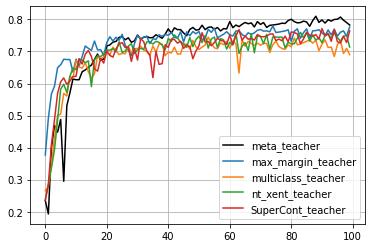

In [51]:
x_len= np.arange(100)

student_alone= np.load('D:/wml_outputs/0424_contrastive/student_alone.npy')
teacher_alone= np.load('D:/wml_outputs/0424_contrastive/teacher_alone.npy')

meta_student= np.load('D:/wml_outputs/0424_contrastive/meta_student.npy')
meta_teacher= np.load('D:/wml_outputs/0424_contrastive/meta_teacher.npy')

max_margin_student= np.load('D:/wml_outputs/0424_contrastive/max_margin_contrastive_loss_euclidean_student.npy')
max_margin_teacher= np.load('D:/wml_outputs/0424_contrastive/max_margin_contrastive_loss_euclidean_teacher.npy')
multiclass_student= np.load('D:/wml_outputs/0424_contrastive/multiclass_npairs_loss_student.npy')
multiclass_teacher= np.load('D:/wml_outputs/0424_contrastive/multiclass_npairs_loss_teacher.npy')
nt_xent_student= np.load('D:/wml_outputs/0424_contrastive/supervised_nt_xent_loss_student.npy')
nt_xent_teacher= np.load('D:/wml_outputs/0424_contrastive/supervised_nt_xent_loss_teacher.npy')
SuperCont_student= np.load('D:/wml_outputs/0424_contrastive/SupervisedContrastiveLoss_student.npy')
SuperCont_teacher= np.load('D:/wml_outputs/0424_contrastive/SupervisedContrastiveLoss_teacher.npy')
triplet_student= np.load('D:/wml_outputs/0424_contrastive/triplet_loss_student.npy')
triplet_teacher= np.load('D:/wml_outputs/0424_contrastive/triplet_loss_teacher.npy')


empty= np.zeros(25)
empty[:]=np.NaN
student_alone_2= np.hstack([student_alone,empty])
empty_2= np.zeros(75)
empty_2[:]=np.NaN
meta_student_2= np.hstack([meta_student[:25], empty_2])

# plt.plot(x_len, student_alone_2, '-', color='grey', label='student_alone')
# plt.plot(x_len, teacher_alone, '-', color='grey', label='teacher_alone')

# plt.plot(x_len, meta_student_2, '-', color='black', label='meta_student')
plt.plot(x_len, meta_teacher, '-', color='black', label='meta_teacher')

#plt.plot(x_len, max_margin_student, '-', label='max_margin_student')
plt.plot(x_len, max_margin_teacher, '-', label='max_margin_teacher')
#plt.plot(x_len, multiclass_student, '-', label='multiclass_student')
plt.plot(x_len, multiclass_teacher, '-', label='multiclass_teacher')
#plt.plot(x_len, nt_xent_student, '-', label='nt_xent_student')
plt.plot(x_len, nt_xent_teacher, '-', label='nt_xent_teacher')
#plt.plot(x_len, SuperCont_student, '-', label='SuperCont_student')
plt.plot(x_len, SuperCont_teacher, '-', label='SuperCont_teacher')
#plt.plot(x_len, triplet_student, '-', label='triplet_student')
# plt.plot(x_len, triplet_teacher, '-', label='triplet_teacher')

plt.legend()
plt.grid()
plt.show()